In [ ]:
import warnings
warnings.filterwarnings('ignore')

#### **API 키 설정**

In [75]:
import os
os.environ['OPENAI_API_KEY'] = "내 OPENAI API 키"
os.environ['TAVILY_API_KEY'] = "내 TAVILY API 키"

### Adaptive RAG 구축하기

Adaptive RAG는 기존에 배웠던 Self-RAG, Agentic-RAG, Corrective-RAG 에서 실행했던 여러가지 기능들을 모두 합한

하나의 완전체 같은 성격을 띠고 있는 RAG 시스템이다.

특히 여러개의 벡터DB를 관리하거나 또는 여러가지 소스를 참고해서 사용자의 답변에 어떻게든 온전한 답변을 할 수 있게 만드는 시스템 이라고 한다면

쿼리 의도 파악 과정에서 적절한 DB를 연결하여 올바른 답변 유도할 수 있기떄문에 효과적인 RAG 시스템이다.

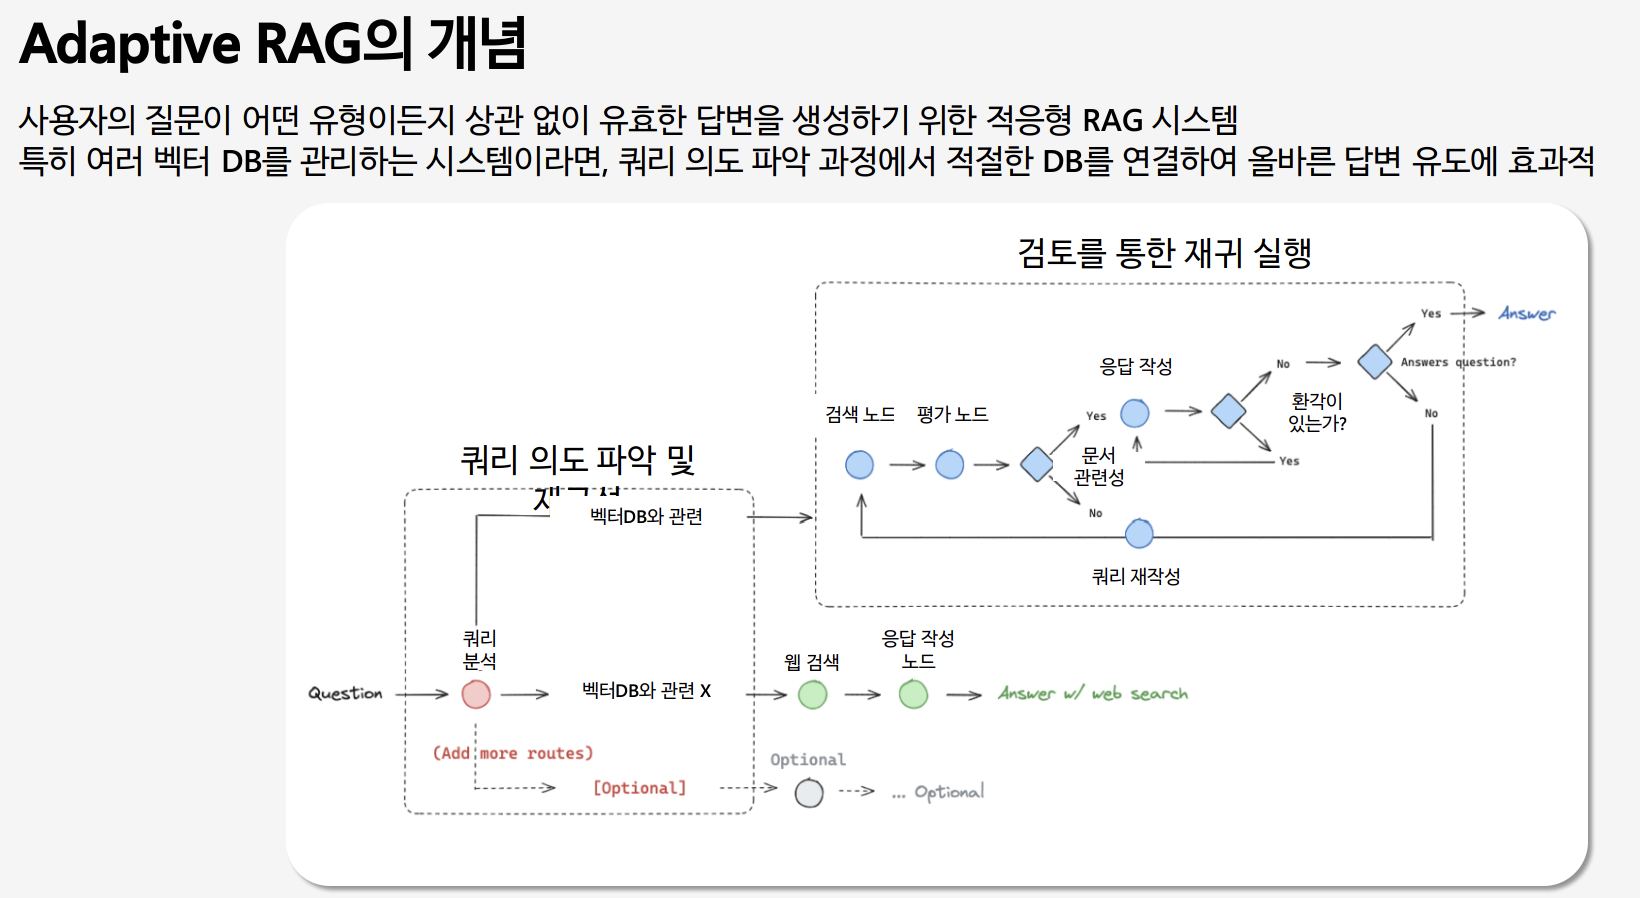

#### **WebBaseLoader로 웹페이지 내 텍스트를 Vector DB로 저장하고 Retriever로 만들기**

In [81]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

embd = OpenAIEmbeddings() # OpenAI 임베딩 함수 사용

# 가져올 텍스트 url 선언
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# WebBaseLoader를 통해 각 url안에 있는 텍스트를 가져와 docs_list에 저장
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# 500자씩 텍스트를 끊기위해 설정
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)

# 500자씩 끊어 doc_splits에 저장
doc_splits = text_splitter.split_documents(docs_list)

# 어떤 문서들을 임베딩벡터로 변환해서 저장할거냐면, 
vectorstore = Chroma.from_documents(
    documents=doc_splits, # 500자씩 분할된 텍스트들을 임베딩해서 저장을 하겠다 정의
    collection_name="rag-chroma", # 크로마벡터db안에 저장할 폴더이름
    embedding=embd, # 어떤 임베딩함수를 쓸건지, 어떤 임베딩 모델을 쓸건지 (위에 정의한 OpenAI꺼 사용)
)

# as_retriever함수를 통해 이 벡터db를 검색가능한 검색기 형태로 만들어줌
retriever = vectorstore.as_retriever()

#### **사용자 질문 의도에 따른 분기**

In [83]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel, Field



# Data model
# 사용자 질문이 들어왔을 때, 어떤 정보를 참고해야되는지에 대해서 라우팅 역할을 해주는 체인을 만들어야되기 때문에 데이터 모델 실행 
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource.""" # docStiring은 원하는 형태로 데이터모델이 정의된 설명을 적어줌 

    datasource: Literal["vectorstore", "web_search"] = Field( # datasource 키값에 Literal안에 "vectorstore", "web_search"를 넣어줌 (Literal 리스트안에 넣어주면 리스트안에 있는 값들 중에 하나를 value로 가져야 된다고 정의)
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.", # 결과값으로 vectorstore나 web_search 둘 중 하나가 정의가 되는데 그것들의 의미는 질문이 들어왔을때 웹검색을 할지 벡터스토어로 보낼지에 대해서 결정하는 스트럭쳐를 정의함 
    )              # (사용자 질문이 주어지면 웹 검색이나 벡터스토어로 라우팅하도록 선택하세요.)


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery) # with_structured_output를 통해 RouteQuery클래스를 넣어주면 선언한 데이터모델에 따라서 답변이 나오게 된다.

# Prompt
# 첫째줄은 사용자의 질문에 따라서 웹검색에 보낼지 벡터스토어에 보낼지 너가(ai) 결정하는 전문가 라는 프롬프트를 주고
# 중요한건 두번째 줄부터, 벡터스토어가 갖고있는 문서가 뭔지, 그렇지 않은경우에는 어떻게 해야하는지에 대해서 명시를 명확하게 해줌.
# 내가 가지고있는 벡터db내에 정보들이 어떤것이 있는지를 명확하게 명시를 해주는게 중요함 그렇지 않은경우 web-search를 쓰겠다고 마지막에 명시해줌
# 만약 이부분이 제대로 설명이 안돼있다면 LLM이 판단하기에 RouteQuery에 결과값 반환 스트럭쳐는 제대로 정의돼있는데 주어진 사용자의 질문이 정확이 어떤 정보로 가야되는지에 대한 로직이 LLM에 의해서 다 정해지기 때문에 그런 경우에 우리가 원하는 결과물을 얻을 수가 없다.
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

# 위 시스템 메세지 선언한걸 가져와 정의하고 human 메세지는 사용사 질문을 넣어줌
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# route_prompt 와 structured_llm_router을 체인으로 엮어줌
question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "Who will the Bears draft first in the NFL draft?"} # 이 질문은 벡터스토어 안에 있는 것과는 관련이 없기때문에 결과가 웹검색으로 나와야한다.
    )
)
# 아래 결과를 보면 datasource 키값에 web_search value가 출력되는걸 볼 수 있다.

datasource='web_search'


#### **문서 관련성 검토 Chain 정의하기**

In [85]:
# 문서 관련성 검토 Chain도 사용자의 질문과 검색 된 문서를 비교 했을 때 나오는 결과값이 binary_score로 나오도록 스트럭쳐를 짜줌
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'" # 결과값은 yes 또는 no로 나오게
    )


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments) # llm한테 with_structured_output을 통해 GradeDocuments을 넣어줌

# 시스템 메세지 - 검색된 문서가 사용자의 질문과 관련이 있는지에 대해 판단하는 grader(채점자)이다
#            - 만약에 검색된 문서가 사용자의 질문과 연관있는 키워드를 담고 있거나 그런 의미를 갖고 있으면 관련성 있는 것으로 판단해야한다.
#            - 엄격한 테스트일 필요는 없고, 목표는 잘못된 검색을 필터링하는 것입니다.
#            - 문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' 또는 'no'를 부여합니다.
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
# 시스템 메세지 와 사용자 질문 템플릿을 만들어 grade_prompt애 저장 
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# 체인 만들기 (사용자의 질문과 리트리버에서 검색된 문서들이 관련이 있는지에 대해서 판단하는 체인)
retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory" # agent memory라는 질문을 넣었다면
docs = retriever.invoke(question) # 질문에 검색된 문서들을 docs에 저장
doc_txt = docs[1].page_content # 첫번째 값에 대해서 
print(retrieval_grader.invoke({"question": question, "document": doc_txt})) # 사용자의 질문과 관련이 있었는지에 대해서 판단

# 아래 결과를 보면 binary_score키값이 no 라고 나왔다.
# 첫번째 page_content가 뭔지는 모르곘지만, 사용자의 질문과 관련이 없다라고 판단된 것을 볼 수 있다.

binary_score='no'


#### **답변 작성 Chain 정의하기**

In [87]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# RAG에 의한 답변생성 체인을 구축
rag_chain = prompt | llm | StrOutputParser()

# 이걸 invoke할때는 두개의 인수가 필요 context에는 우리가 리트리버에서 검색된 문서 docs, question에는 사용자질문 question을 넣어줌
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation) # 출력

C:\Users\user\anaconda3\envs\fastcampus\Lib\site-packages\langsmith\client.py:312: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Agent memory in LLM-powered autonomous agents refers to a long-term memory module that records experiences in natural language, allowing agents to behave based on past interactions. This memory stream captures observations and events, which can be used to inform future actions through a retrieval model that assesses relevance, recency, and importance. Additionally, a reflection mechanism synthesizes these memories into higher-level inferences to guide the agent's behavior over time.


#### **환각 검토 Chain 정의하기**

In [89]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# 시스템 메세지
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

# 앞서서 검색한 문서들과 LLM이 생성한 답변을 모두 가지고 있기 때문에 hallucination_grader을 했을때 
# 아래 결과처럼 우리가 설정했던 데이터 모델에 스트럭쳐 아웃풋을 재대로 출력하고 있는걸 볼 수 있다. 

GradeHallucinations(binary_score='yes')

#### **답변 적절성 검토 Chain 정의하기**

In [91]:
# 위 랑 같은 로직으로 작성

class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

# 아래 결과를 보면
# 사용자의 질문과 LLM이 생성한 답변이 관련이 있다 라고 판단되어 출력 되고 있다.

GradeAnswer(binary_score='yes')

#### **질문 재작성 Chain 정의하기**

In [93]:
# 질문 재작성 chain의 경우는 스트럭처 아웃풋이 필요없음 사용자의 질문을 그냥 또 하나의 다른 문장으로 만들어내는 것이니까

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt
# 시스템 메세지에 사용자의 질문을 어떤식으로 재정의 할지에 대해서만 잘 적어주면된다.
# 이것도 각자 시스템에 따라서 질문을 재작성하는 방식이 달라질 수 있다. 근데 통용적으로 아래 프롬프트처럼 "사용자 질문에 진위 여부를 파악하고 그걸 기반으로 조금 더 벡터db 검색에 최적화된 형태로 질문을 바꿔라" 라고하면 문장이 꽤 깔끔하게 잘 나온다.
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

# 아래 재작성된 질문 결과를 보자 
# 처음에 agent memory 라는 질문을 했었는데.
# 이번엔 조금 더 많은 정보를 담고있는 하나의 문장으로 내 질문이 재작성 되어 나온걸 볼 수 있다.

'What are the key concepts and techniques related to agent memory in artificial intelligence?'

#### **웹 검색 도구 정의하기**

In [95]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

#### **GraphState 정의하기**

In [97]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str # 사용자 질문
    generation: str # LLM이 생성한 답변 
    documents: List[str] # 답변을 생성하는데 쓰였던 문서들을 키값으로 정의

#### **위에서 정의한 Chain을 기반으로 노드 함수 정의하기**

In [99]:
from langchain.schema import Document

# 사용자의 질문에 대해서 retriever를 실행한 결과를 documents에 저장을 하고 documents와 question을 업데이트하는 역할
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question) # 사용자의 질문에 대해서 retriever를 실행한 결과를 documents에 저장
    return {"documents": documents, "question": question} # documents와 question을 업데이트하는 역할

# 앞에 선언을 했던 RAG답변 생성을 위한 rag_chain에 invoke한 결과물을 generation에 담아 generation 키값에 넣어 업데이트해줌
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question}) # rag_chain에 invoke한 결과물을 generation에 담음
    return {"documents": documents, "question": question, "generation": generation} # generation 키값에 넣어 업데이트해줌

# 
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"] # 사용자의 질문과
    documents = state["documents"] # 검색된 문서들을 저장

    # Score each doc
    filtered_docs = []
    for d in documents: # 문서들을 for문으로 순회하면서 
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes": # 만약 질문과 관련이 있다면
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d) # 리스트에 관련있는 해당 문서 추가
        else: # 관련이 없는 경우에는 스킵
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question} # filtered_docs에는 관련이 있는 문서만 저장이 된다.

# 질문 재작성은 사용자의 질문이 들어왔을때 question_rewriter만 실행하면 됨
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question} # question 키값에 업데이트 해줌

# 웹검색
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question}) # 사용자의 질문을 기반으로 해서 web_search_tool을 실행
    web_results = "\n".join([d["content"] for d in docs]) # 그렇게 나온 웹검색 결과를 모두 조인해서 
    web_results = Document(page_content=web_results) # Document객체로 만들어줌

    return {"documents": web_results, "question": question} # documents키값에 web_results를 담아 llm이 해당 소스를 기반으로 사용자의 질문을 답변할 수 있도록 만들어줌


### Edges ###

# route_question는 사용자 질문이 들어왔을때 바로 분기를 시켜주는 로직
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"] # 사용자의 질문이 들어오면 
    source = question_router.invoke({"question": question}) # question_router를 통해 어떤 소스에 참고해야될지를 source에 저장
    if source.datasource == "web_search": # datasource 키값을 통해 웹검색인지
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search" # 사용자의 질문이 웹검색에 적합하면 웹검색 노드로 연결
    elif source.datasource == "vectorstore": # 벡터스토어 인지를 확인함 
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore" # 벡터스토어에 적합하면 해당 노드로 연결

# 
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"] # 앞에 필터링된 문서들을 저장했었는데 

    # 저장된 연관성있는 필터 문서들 중에 만약에 filtered_documents가 없었다. 즉 사용자의 질문과 관련된 문서가 하나도 없다면 transform_query를 반환
    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query" 
    else: # 그렇지 않으면 답변을  생성
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

# 환각현상 검토와 답변 적절성 검토를 모두 수행하는 로직
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

#### **그래프 구축하기**

In [101]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

#### **그래프 시각화**

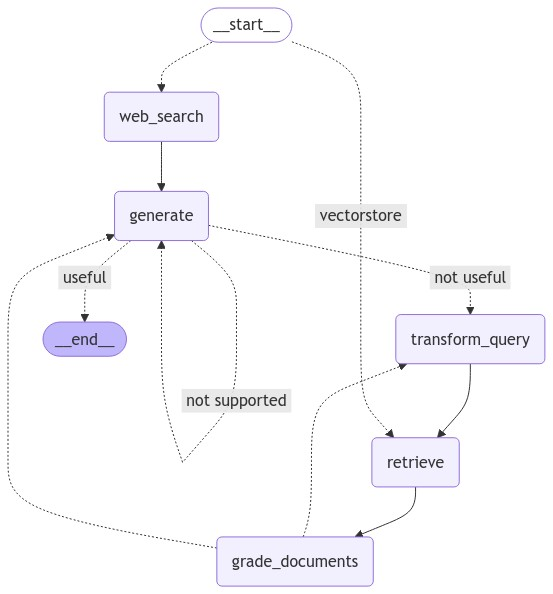

In [103]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [105]:
%%time
import time # 답변 생성 시간이 얼마나 걸리는지 한번 체크해보기 위해 사용

# Run
# 이번엔 아까와 같이 NFL같은 질문을 해서 벡터스토어가 아닌 웹검색을 하도록 해서 답변을 받아보자
inputs = {
    "question": "What player at the Bears expected to draft first in the 2024 NFL draft?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
print(value["generation"])

# ROUTE QUESTION TO WEB SEARCH로 가겠다고 판단을 하고 web_search 노드를 실행한다.

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
Node 'web_search':

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
Node 'generate':

---

The Chicago Bears selected USC quarterback Caleb Williams with the No. 1 pick in the 2024 NFL Draft. He was widely regarded as the top prospect in the draft class.
CPU times: total: 15.6 ms
Wall time: 6.51 s


In [107]:
%%time
# Run
# 이번엔 벡터스토어 안에서 답변을 할 수 있게 질문을 해보았다.
inputs = {"question": "에이전트 메모리의 종류별 특징에 대해서 설명해줘"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
print(value["generation"])

# ROUTE QUESTION TO RAG로 가겠다고 판단을 하고 retrieve 노드를 실행한다.
# 총 4개의 검색된 문서가 있었는데 그중에 두개의 연관된 문서가 있어 그대로 GENERATE해서 grade_documents 노드로 이동
# 그 다음 환각현상과 답변 적절성 까지 판단을 해서 generate 단계를 거쳐 최종 답변을 낸것을 볼 수 있다.

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
Node 'retrieve':

---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
Node 'grade_documents':

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
Node 'generate':

---

에이전트 메모리의 종류에는 감각 기억, 단기 기억(작업 기억), 장기 기억이 있습니다. 감각 기억은 짧은 시간 동안 감각 정보를 유지하며, 단기 기억은 현재 인식하고 있는 정보를 저장하여 복잡한 인지 작업을 수행하는 데 사용됩니다. 장기 기억은 정보를 오랜 기간 저장할 수 있으며, 명시적 기억(사실과 사건)과 암묵적 기억(자동으로 수행되는 기술)으로 나뉩니다.
CPU times: total: 46.9 ms
Wall time: 6.32 s


Adaptive RAG에 대해서 알아보았다.

여러가지 노드를 통해 기존 RAG에 많은 한계점들을 돌파할 수 있었던것 만큼 그만큼의 trade off(하나가 증가하면 하나가 감소)로써 응답 시간이 좀 늦고 비용이 그만큼 많이 발생한다.

꼭 기존 RAG 시스템에 문제점이 그렇게 크지 않다면 굳이 이런 RAG시스템까지 구축하지 않아도 된다. (trade off가 있기떄문에)

하지만 Naive RAG를 쓰는 사람들의 페이포인트가 워낙 크기 떄문에 기존에 해결 불가능했던 부분을 이런 시스템을 통해서 해결할 수 있다 라고 한다면

우리가 갖고있는 벡터db베이스 또는 RAG Tool 이런것들과 잘 결합을 해서 이런 시스템을 만든다고 하면 굉장히 정확한 답변을 낼 수 있기 때문에 

강력한 시스템이 될 수 있다.